## ITDI Shared Task @ VarDial 2022 submission


In this notebook, we briefly introduce how to train and validate the Logistic Regression model developed to tackle the Identification of Languages and Dialects of Italy task from VarDial 2022 shared task. 

### Data loading
Firstly, we import some useful libraries and read the training and development data.

In [2]:
import pandas as pd
from utils import explain_label
from sklearn.model_selection import train_test_split

In [10]:
data_train = pd.read_csv("train.csv")
data, labels = data_train['text'].values, data_train['label'].values.astype(int)
_, data, _, labels = train_test_split(data, labels, test_size=0.1, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.4, random_state=1)

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

data_train = pd.read_csv("train.csv")
data, labels = data_train['text'].values, data_train['label'].values.astype(int)

_, data, _, labels = train_test_split(data, labels, test_size=0.1, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.4, random_state=1)

vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)


# Model training


## Logistic Regression

Import and initialize the logistic regression model. Fit it using the given training and validation data.

In [29]:
from models import LogisticRegressionITDI

model = LogisticRegressionITDI(verbose=1)
_, _, cm = model.fit(X_train=X_train, y_train=y_train, X_val=X_test, y_val=y_test)

Vectorizing and normalizing training data...
Fitting Logistic Regression...
Evaluating the model...
Training completed, train_f1 : 0.999786734911495, val_f1 : 0.9844849648112604


Finally, plot the confusion matrix for the validation set.

In [20]:
print(cm.shape)

(5, 5)


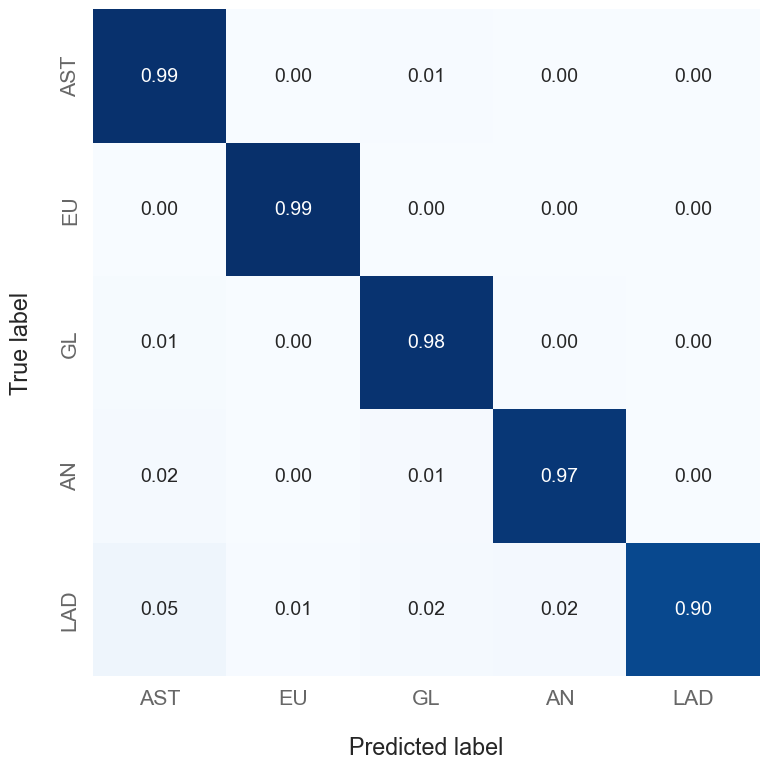

In [21]:
from utils import explain_label
import matplotlib.pyplot as plt
import seaborn as sns

df_cm = pd.DataFrame(cm, index = [explain_label(i)[:3] for i in range(0,5)], columns = [explain_label(i)[:3] for i in range(0,5)])

plt.figure(figsize = (8, 8))
sns.set(font_scale=1.4) # for label size
ax = sns.heatmap(df_cm, 
            annot=True, 
            annot_kws={"size": 14}, 
            fmt='.2f', 
            cmap="Blues",
            cbar=False) 

plt.xlabel("Predicted label", labelpad=20)
plt.ylabel("True label", labelpad=20)

plt.setp(ax.get_xticklabels(), alpha=0.7)
plt.setp(ax.get_yticklabels(), alpha=0.7)

plt.tight_layout()  
plt.show()

Predict for the validation set and print some nice metrics for the dialects. 

In [22]:
pred = model.predict(X_test)

In [23]:
from sklearn.metrics import classification_report
from sklearn.exceptions import UndefinedMetricWarning
import warnings

with warnings.catch_warnings(): 
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
    print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     10872
           1       0.99      0.99      0.99     12376
           2       0.98      0.98      0.98      8008
           3       0.98      0.97      0.97      5562
           4       0.99      0.90      0.95       694

    accuracy                           0.98     37512
   macro avg       0.99      0.97      0.98     37512
weighted avg       0.98      0.98      0.98     37512



### Inference
And now, some inference! Let's try to classify some Spanish dialects sentences that are not in the training set.

In [24]:
sentence = "estió un monesterio establito en se devantó a ma regla que dimpués fue seguita por cuantos monesterios griegos"
explain_label(model.predict(sentence)[0])

'AN'

In [25]:
sentence = "liña en universal"
explain_label(model.predict(sentence)[0])

'GL'

In [26]:
sentence = "lleis fonétiques sistemáticu palatalizan evolución"
explain_label(model.predict(sentence)[0])

'AST'

## Random Forest

Here we are going to use random forest to try and determine the dialects


In [36]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth=128, min_samples_split=4)
clf.fit(X_train_vectorized, y_train)

RandomForestClassifier(max_depth=128, min_samples_split=4)

In [37]:
from sklearn.metrics import accuracy_score
y_pred = clf.predict(X_test_vectorized)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9401791426743442


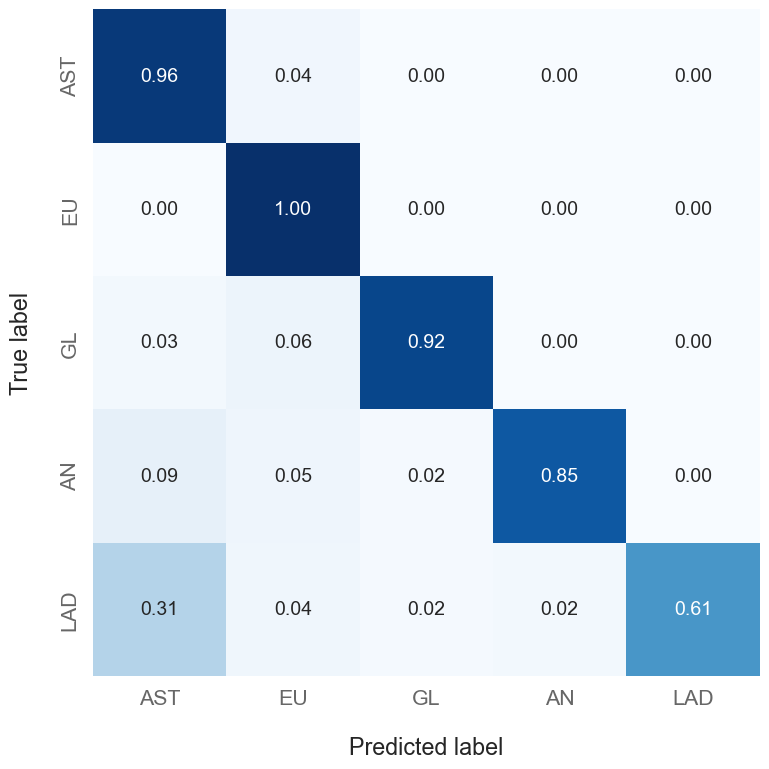

In [41]:
import numpy as np
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a dataframe from the normalized confusion matrix
df_cm = pd.DataFrame(cm_normalized, index=[explain_label(i)[:3] for i in range(0, 5)], columns=[explain_label(i)[:3] for i in range(0, 5)])

# Plot the normalized confusion matrix
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.4)  # for label size
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt='.2f', cmap="Blues", cbar=False)
plt.xlabel("Predicted label", labelpad=20)
plt.ylabel("True label", labelpad=20)
plt.setp(ax.get_xticklabels(), alpha=0.7)
plt.setp(ax.get_yticklabels(), alpha=0.7)
plt.tight_layout()
plt.show()


In [42]:
pred = clf.predict(X_test_vectorized)



In [43]:
from sklearn.metrics import classification_report
from sklearn.exceptions import UndefinedMetricWarning
import warnings

with warnings.catch_warnings(): 
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
    print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     10872
           1       0.92      1.00      0.96     12376
           2       0.98      0.92      0.95      8008
           3       0.99      0.85      0.91      5562
           4       1.00      0.61      0.76       694

    accuracy                           0.94     37512
   macro avg       0.96      0.87      0.90     37512
weighted avg       0.94      0.94      0.94     37512



In [49]:
print(X_train.shape[0])

56268


## Naive Bayes

For our third approach we use naive Bayes and fit it to our vectorized data.

In [4]:
from sklearn.naive_bayes import GaussianNB

# Create an instance of the Naive Bayes classifier
nb = GaussianNB()

# Fit the classifier to the training data
nb.fit(X_train_vectorized.toarray(), y_train)



GaussianNB()

In [5]:
y_pred = nb.predict(X_test_vectorized.toarray())
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


NameError: name 'accuracy_score' is not defined

In [6]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)



Accuracy: 0.9601194284495628


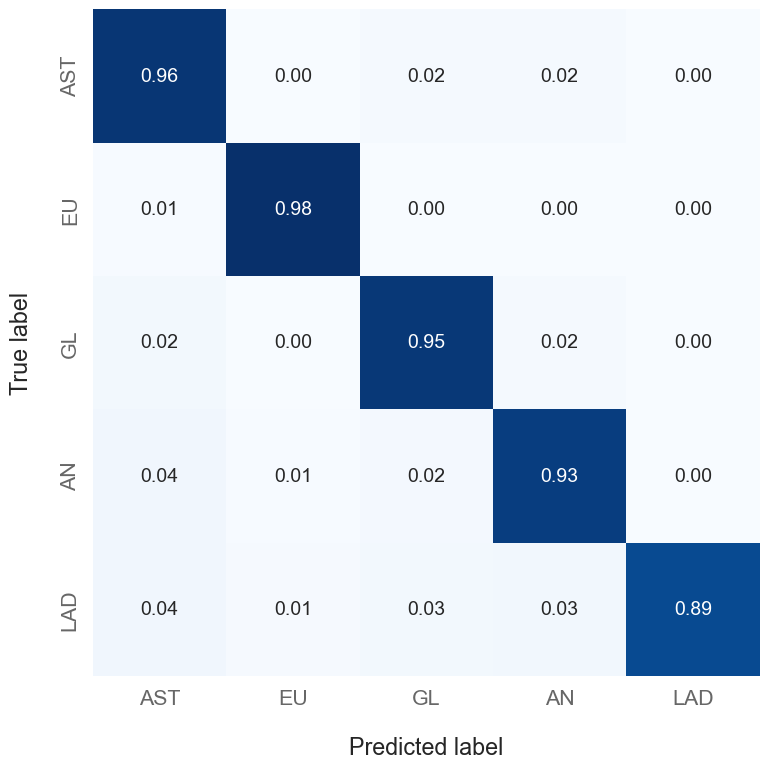

In [13]:
import numpy as np

from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm_normalized, index=[explain_label(i)[:3] for i in range(0, 5)], columns=[explain_label(i)[:3] for i in range(0, 5)])

# Plot the normalized confusion matrix
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.4)  # for label size
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt='.2f', cmap="Blues", cbar=False)
plt.xlabel("Predicted label", labelpad=20)
plt.ylabel("True label", labelpad=20)
plt.setp(ax.get_xticklabels(), alpha=0.7)
plt.setp(ax.get_yticklabels(), alpha=0.7)
plt.tight_layout()
plt.show()